In [263]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

**Migration + Equilibrium tides + Obliquity evolution tutorial**

*Authors: Dang Pham, Michael Poon (equal contribution)*

In this tutorial, we reproduce the obliquity evolution for a 2-planet + star system that gets captured into near 3:2 mean motion resonance. Our setup follows [Millholland+Laughlin2019](https://ui.adsabs.harvard.edu/abs/2019NatAs...3..424M/abstract) and [Lu+2023](https://ui.adsabs.harvard.edu/abs/2023arXiv230300006L/abstract), and is the first python implementation (to our knowledge).

Our simulation is set up in rebound, with migration and tidal dissipation effects implemented in reboundx. We note that although ML19 and Lu+2023 do not explicitly mention an initial inclination for the planets, we found that coplanar systems cannot excite equilibrium tides. As a result, we set the inclination of the planets to be ~0.5 degrees (REBOUNDx documentation), which leads to nonzero obliquity evolution.

In addition, we changed the following parameters for faster resonance capture: $\tau_{a,1}, \tau_{a,2}$, integration time. Essentially, our system gets captured into resonance much faster than ML19 by having a faster damping timescale.

### 1. Migration

First, we set up the two planets and the star, according to ML19.

In [264]:
# setup planet mass, eccentricity, radius in M_sun, AU units
planet_mass = 1.5017446744253966e-05 # 5 M_earth
planet_ecc = 0.01
planet_radius = 0.00010658741281135093 # 2.5 R_earth
star_radius = 0.004650467260962157 # 1 R_earth

In [265]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.23,
        e=planet_ecc, r=planet_radius, hash="p2")
sim.move_to_com()

# using WHFast with planet period = planet period / 10.134
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 15.1234

Next, we add semimajor axis damping forces (approximation of a type I disk migration damping), where the damping timescale is set according to ML19.

In [266]:
# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
τ1 = 0.125e6 * (2 * np.pi) # 5e6 in ML19
τ2 = τ1 / 1.1
ps[1].params["tau_a"] = -τ1
ps[2].params["tau_a"] = -τ2
rebx.add_force(mof)

Now, we integrate until 2 million years, then switch off the damping, then migrate for until 4 million years.

In [267]:
# integrate until 100,000 years (c.f. ML19's 4 million years)
tmax = 1.e5
N_outputs = 100

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units

# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., tmax / 2, N_outputs // 2) * (2*np.pi)

# storing semimajor axis, eccentricity, and inclination
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    sim.integrate(t, exact_finish_time=1)
    
    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

# integrate the rest of the way
t_arr = np.linspace(tmax / 2, tmax, N_outputs // 2) * (2*np.pi)

for i, t in enumerate(t_arr):
    sim.integrate(t, exact_finish_time=1)

    ps = sim.particles
    a[i + N_outputs // 2] = [ps[1].a, ps[2].a]
    ecc[i + N_outputs // 2] = [ps[1].e, ps[2].e]
    inc[i + N_outputs // 2] = [ps[1].inc, ps[2].inc]

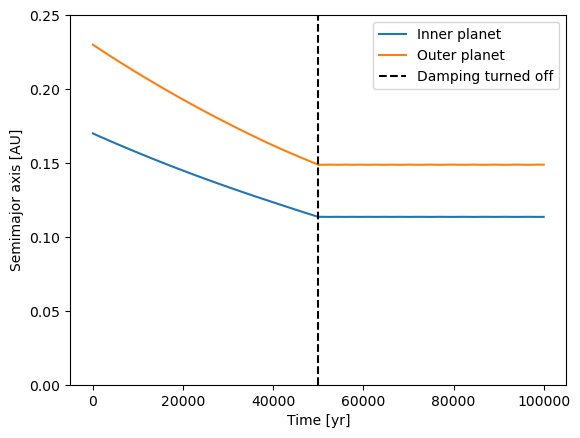

In [268]:
# make time array for plotting
t_plot = list(np.linspace(0., tmax / 2, N_outputs // 2)) + list(np.linspace(tmax / 2, tmax, N_outputs // 2))

plt.plot(t_plot, a[:,0], label="Inner planet")
plt.plot(t_plot, a[:,1], label="Outer planet")
plt.axvline(tmax / 2, color="k", linestyle="--", label="Damping turned off")
plt.ylim([0., 0.25])
plt.ylabel("Semimajor axis [AU]")
plt.xlabel("Time [yr]")
plt.legend()


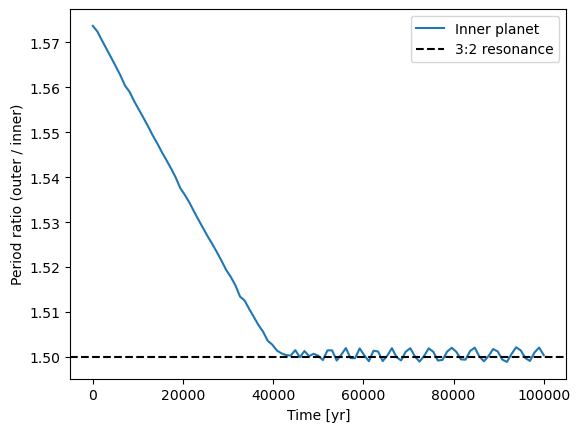

In [269]:
plt.plot(t_plot, (a[:,1] / a[:,0])**(3./2.), label="Inner planet")
plt.ylabel("Period ratio (outer / inner)")
plt.xlabel("Time [yr]")
plt.axhline(1.5, color="k", linestyle="--", label="3:2 resonance")
plt.legend()

We can see here that the planets get captured into a 3:2 resonance at about 1.5 million years. There are small oscillations as the planets slightly offset from resonance.

### 2. Migration with equilibrium tides and obliquity evolution

In this section, we seek to reproduce Figure 3 of ML19 until 2 million years. We only integrate until 2 million years instead of 4 million years due to intensive integration times.

First, we set up the basic simulation with migration forces as above.

In [270]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

In [271]:
def angle_between_vecs(vec1, vec2):
    """ Calculate the angle between two vectors"""
    dot_prod = np.dot(vec1, vec2)
    norm_prod = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    return np.arccos(dot_prod / norm_prod)

In [272]:
# setup planet mass, eccentricity, radius in M_sun, AU units
planet_mass = 1.5017446744253966e-05 # 5 M_earth
planet_ecc = 0.01
planet_radius = 0.00010658741281135093 # 2.5 R_earth
star_radius = 0.004650467260962157 # 1 R_earth

In [302]:
# set up rebound
sim = rebound.Simulation()
sim.G = 1.
sim.add(m=1., r=star_radius, hash="star")
sim.add(m=planet_mass, a=0.17, 
        e=planet_ecc, r=planet_radius, hash="p1")
sim.add(m=planet_mass, a=0.23,
        e=planet_ecc, r=planet_radius, hash="p2")
sim.move_to_com()

# using WHFast with planet period = planet period / 15.134
ps = sim.particles
sim.integrator = "whfast"
sim.dt = ps[1].P / 15.1234

# add migration forces with characteristic timescales
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces")
τ1 = 0.125e6 * (2 * np.pi) # 5e6 in ML19
τ2 = τ1 / 1.1
ps[1].params["tau_a"] = -τ1
ps[2].params["tau_a"] = -τ2
rebx.add_force(mof)

Next, we set up the equilibrium tides, with the same parameters as ML19.

In [303]:
sf = rebx.load_force("tides_spin")
rebx.add_force(sf)

# Star parameters
# Stellar rotation period = 20 days
Prot_star = 20 * (2*np.pi)# days
C_star = 0.07 # normalized moment of inertia
Q_star = 1e4 # tidal quality factor for the star, should be 1e6
ps[0].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(20/365), theta=0., phi=0.)
ps[0].params['I'] = C_star * ps[0].m * ps[0].r**2
ps[0].params['tau'] = 1./(2.* Q_star * ps[1].n)

# Planet parameters
C_planet = 0.25 # normalized moment of inertia
Prot_planet1 = 5 * (2*np.pi)# days
initial_obliquity = 15 # degrees, should be 1 degrees
Q_planet = 5e2 # should be 1e4 from ML19
ps[1].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(Prot_planet1/365), theta=np.radians(initial_obliquity), phi=0.)
ps[1].params['I'] = C_planet * ps[1].m * ps[1].r**2
ps[1].params['tau'] = 1./(2.* Q_planet * ps[1].n)

Prot_planet2 = 3 * (2*np.pi) #days
ps[2].params['Omega'] = rebound.spherical_to_xyz(magnitude=(2*np.pi)/(Prot_planet2/365), theta=np.radians(initial_obliquity), phi=0.)
ps[2].params['I'] = C_planet * ps[2].m * ps[2].r**2
ps[2].params['tau'] = 1./(2.* Q_planet * ps[2].n)

# Set k2 Love numbers so planets feel tides and deform from perfect spheres
ps[0].params['k2'] = 0.07
ps[1].params['k2'] = 0.4
ps[2].params['k2'] = 0.4

In [304]:
# initialize spin ODEs
rebx.initialize_spin_ode(sf)

Now, let's integrate until 2 million years (ML19 runs for 4 million years, but that is quite computationally intensive).

In [305]:
# integrate until 2 millions years
tmax = 4.e4
N_outputs = 100_000

# set up arrays to store orbital elements
# 2 pi factors are to convert from yr to yr/2pi units

# here, we're integrating half of the way first
# then switch off migration forces
t_arr = np.linspace(0., tmax, N_outputs) * (2*np.pi)

# storing semimajor axis, eccentricity, inclination, and obliquity
a = np.zeros((N_outputs,2))
ecc = np.zeros((N_outputs,2))
inc = np.zeros((N_outputs,2))
obliquity = np.zeros((N_outputs,2))

for i, t in enumerate(t_arr):
    sim.integrate(t)

    ps = sim.particles
    a[i] = [ps[1].a, ps[2].a]
    ecc[i] = [ps[1].e, ps[2].e]
    inc[i] = [ps[1].inc, ps[2].inc]

    Omega_planet1 = ps[1].params["Omega"]
    Omega_planet2 = ps[2].params["Omega"]
    orbit_normal1 = ps[1].hvec
    orbit_normal2 = ps[2].hvec
    theta1 = angle_between_vecs(Omega_planet1, orbit_normal1)
    theta2 = angle_between_vecs(Omega_planet2, orbit_normal2)

    obliquity[i] = [np.degrees(theta1), np.degrees(theta2)]

# switch off migration
ps[1].params["tau_a"] = np.inf
ps[2].params["tau_a"] = np.inf

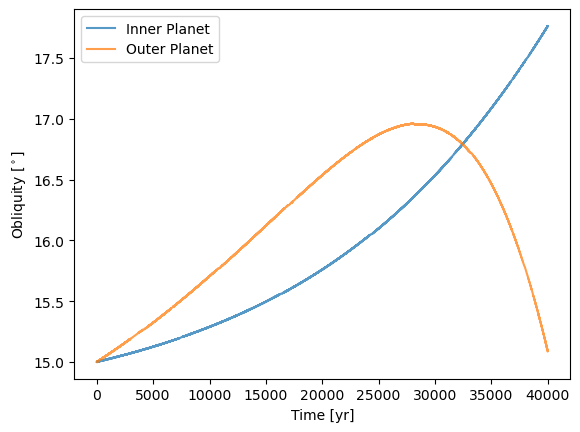

In [306]:
plt.plot(t_arr / (2*np.pi), obliquity[:,1], '-', alpha=0.75, label="Inner Planet")
plt.plot(t_arr / (2*np.pi), obliquity[:,0], '-', alpha=0.75, label="Outer Planet")
plt.xlabel("Time [yr]")
plt.ylabel(r"Obliquity [$^\circ$]")
plt.legend();